# VLM-RAG Test Notebook

## System Components:
1. **Vector Database** - ChromaDB for storing past interactions
2. **Visual Interpreter** - OpenRouter API for vision models 
3. **Validation Judge** - LLM judge for comparing responses

## Research Questions:
1. To what degree do BLV users visual needs change across similar visual contexts?
2. Can we leverage past users interactions to provide more relevant future visual interpretations?


In [1]:
# Setup and imports
import sys
import os

# Add the parent directory to path so we can import our modules
sys.path.append('..')

# Now we can import from the src directory
from src.vector_db import SimpleVectorDB

# Step 1: Initialize the Vector Database
print("🚀 Initializing Vector Database for Image Embeddings...")

# Initialize the simplified vector database
db = SimpleVectorDB()

print("\n✅ Vector Database initialized!")


🚀 Initializing Vector Database for Image Embeddings...
Vector DB initialized at: ./data/chroma_db
Persistence enabled: Data will be saved to disk

✅ Vector Database initialized!


# Load Collection or Create a new One

In [2]:
print("🗄️ Creating fresh collection for OpenCLIP experiment...")

db.use_collection("vizwiz_500_openclip", "500 random VizWiz samples using OpenCLIP embeddings") 

stats = db.get_collection_stats()
print(f"📊 Fresh collection stats: {stats}")

print("✅ Fresh collection created for OpenCLIP experiment!")

🗄️ Creating fresh collection for OpenCLIP experiment...
Collection 'vizwiz_500_openclip' ready
Now using collection: vizwiz_500_openclip
📊 Fresh collection stats: {'total_images': 500, 'collection_name': 'vizwiz_500_openclip', 'persisted': True}
✅ Fresh collection created for OpenCLIP experiment!


# Load 500 entries from vizwiz

In [5]:
# Step 2: Load Data Splits Based on Existing Cohere JSONs for Consistency
import json
import pandas as pd
from IPython.display import display
from pathlib import Path

print("📝 Loading data splits by reading existing Cohere JSON files to ensure consistency...")

# --- Rutas a los archivos JSON de Cohere existentes ---
cohere_db_path = Path("./data/embeddings/lf_vqa_db_embeddings_cohere.json")
cohere_validation_path = Path("./data/embeddings/lf_vqa_validation_embeddings_cohere.json")

# --- Cargar todos los datos originales (sigue siendo necesario) ---
data_path = Path('./data/original/all.json')
try:
    with open(data_path, 'r') as f:
        all_data = json.load(f)
    print(f"✅ Loaded {len(all_data)} total entries from all.json")
except FileNotFoundError:
    print(f"❌ File '{data_path}' not found! Cannot proceed.")
    all_data = {}

# --- Variables para almacenar nuestros datos ---
sample_data = {}       # Para los 500 de entrenamiento (DB)
validation_sample = [] # Para los ~100 de validación

# --- Procesar el JSON de la BASE DE DATOS de Cohere ---
try:
    with open(cohere_db_path, 'r') as f:
        cohere_db_data = json.load(f)
    # Leemos la lista de "items" para obtener los IDs
    db_ids = [item['id'] for item in cohere_db_data.get('items', [])]
    # Construimos 'sample_data' usando los IDs
    sample_data = {key: all_data[key] for key in db_ids if key in all_data}
    print(f"✅ Se han extraído {len(sample_data)} IDs para el set de entrenamiento desde '{cohere_db_path.name}'.")
except FileNotFoundError:
    print(f"❌ Archivo DB de Cohere no encontrado. No se puede crear un set de entrenamiento consistente.")
except Exception as e:
    print(f"❌ Error al procesar el archivo DB de Cohere: {e}")

# --- Procesar el JSON de VALIDACIÓN de Cohere ---
try:
    with open(cohere_validation_path, 'r') as f:
        cohere_validation_data = json.load(f)
    # Extraemos los IDs de cada item y los asignamos a 'validation_sample'
    validation_sample = [item['id'] for item in cohere_validation_data.get('items', [])]
    print(f"✅ Se han extraído {len(validation_sample)} IDs para el set de validación desde '{cohere_validation_path.name}'.")
except FileNotFoundError:
    print(f"❌ Archivo de validación de Cohere no encontrado. No se puede crear un set de validación consistente.")
except Exception as e:
    print(f"❌ Error al procesar el archivo de validación de Cohere: {e}")

# --- INICIO DE LA SECCIÓN DE VISUALIZACIÓN (IDÉNTICA AL ORIGINAL) ---
# Esta sección confirma visualmente que los datos se cargaron correctamente.

if sample_data:
    print("\n--- Verificación de Datos Cargados ---")
    example_key = list(sample_data.keys())[0]
    example_entry = sample_data[example_key]
    print(f"\n📋 Ejemplo de entrada (ID: {example_key}):")
    for field in ['question', 'answerability', 'question_type', 'crowd_majority', 'image_url']:
        if field in example_entry:
            print(f"  {field}: {example_entry[field]}")
    
    # Display first 10 rows as a table
    print("\n📊 Primeras 10 entradas del set de entrenamiento (consistente con Cohere):")
    sample_rows = []
    for i, (key, data) in enumerate(list(sample_data.items())[:10]):
        sample_rows.append({
            'ID': key,
            'Question': data.get('question', 'N/A'),
            'Answerability': data.get('answerability', 'N/A'),
            'Question Type': data.get('question_type', 'N/A'),
            'Crowd Majority': data.get('crowd_majority', 'N/A'),
            'Image URL': data.get('image_url', 'N/A')
        })
    
    # Create and display DataFrame
    df = pd.DataFrame(sample_rows)
    display(df)
else:
    print("\n⚠️ 'sample_data' está vacío. No se puede mostrar un ejemplo o la tabla.")

📝 Loading data splits by reading existing Cohere JSON files to ensure consistency...
✅ Loaded 600 total entries from all.json
✅ Se han extraído 500 IDs para el set de entrenamiento desde 'lf_vqa_db_embeddings_cohere.json'.
✅ Se han extraído 100 IDs para el set de validación desde 'lf_vqa_validation_embeddings_cohere.json'.

--- Verificación de Datos Cargados ---

📋 Ejemplo de entrada (ID: 596):
  question: what is the scientific name of this leaf?
  answerability: unanswerable
  question_type: Others
  crowd_majority: unanswerable
  image_url: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_val_00002308.jpg

📊 Primeras 10 entradas del set de entrenamiento (consistente con Cohere):


,ID,Question,Answerability,Question Type,Crowd Majority,Image URL
0,596,what is the scientific name of this leaf?,unanswerable,Others,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
1,39,What is this bottle?,answerable,Identification,febreze,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
2,416,For how long do I cook this in the microwave?,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
3,56,What is this?,answerable,Identification,2 water bottles,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
4,31,What is this?,answerable,Identification,jambalaya mix,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
5,230,What color is this highlighter?,answerable,Description,yellow,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
6,372,when did this expire?,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
7,433,"What time does it say, on my set top box? Than...",answerable,Reading,12:10,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
8,308,What does the label say?,answerable,Reading,chap stick,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
9,377,What's the warning label?,answerable,Reading,may cause drowsiness,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...


# Check Collection Currently loaded

In [6]:
stats = db.get_collection_stats()
print(f"📊 Fresh collection stats: {stats}")

📊 Fresh collection stats: {'total_images': 500, 'collection_name': 'vizwiz_500_openclip', 'persisted': True}


## Define embedding generation functions

In [7]:
import torch
from PIL import Image
import open_clip
import requests
from io import BytesIO
import os
import json # Para cargar sample_data si está en un JSON
from tqdm import tqdm # Para barras de progreso si procesas muchas imágenes

In [8]:
print("Cargando modelo OpenCLIP en memoria para el test...")

# *** DETECCIÓN DEL DISPOSITIVO PARA APPLE SILICON (MPS) ***
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available(): # Esto es por si acaso se ejecuta en un sistema con CUDA
    device = "cuda"
else:
    device = "cpu"

# Carga el modelo y la función de preprocesamiento
# Usamos 'ViT-B-32' con los pesos 'laion2b_s34b_b79k' como en el ejemplo anterior
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.to(device) # Mueve el modelo al dispositivo (MPS, CUDA o CPU)
model.eval() # Pone el modelo en modo de evaluación
print(f"Modelo OpenCLIP cargado exitosamente en el dispositivo: {device}\n")

Cargando modelo OpenCLIP en memoria para el test...
Modelo OpenCLIP cargado exitosamente en el dispositivo: mps



In [9]:
def openclip_generate_image_embedding(image_path, model, preprocess, device):
    """
    Genera un embedding para una imagen usando un modelo OpenCLIP pre-cargado.
    
    Args:
    
        image_path (str): Ruta al archivo de imagen o una URL.
        model: El modelo OpenCLIP ya cargado.
        preprocess: La función de preprocesamiento asociada al modelo.
        device (str): El dispositivo donde se ejecuta el modelo ('mps' o 'cpu').
        
    Returns:
        list: Una lista de floats que representa el embedding de la imagen, o None si hay un error.
    """
    try:
        # 1. Cargar la imagen desde la ruta (local o URL)
        if image_path.startswith(('http://', 'https://')):
            response = requests.get(image_path)
            response.raise_for_status()  # Lanza un error si la descarga falla
            image_pil = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            image_pil = Image.open(image_path).convert("RGB")
            
        # 2. Preprocesar la imagen y moverla al dispositivo correcto
        image_tensor = preprocess(image_pil).unsqueeze(0).to(device)
        
        # 3. Generar el embedding
        with torch.no_grad():
            embedding = model.encode_image(image_tensor)
            embedding /= embedding.norm(dim=-1, keepdim=True)
        
        # 4. Devolver el embedding como una lista de Python
        return embedding.cpu().numpy().tolist()[0]

    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")
        return None

## Test embedding functions

In [10]:
first_item = list(sample_data.items())[:1]
if first_item:
    entry_id, entry_data = first_item[0]
    image_url = entry_data.get('image_url', 'No image URL found')
    print(f"Entry ID: {entry_id}, Image URL: {image_url}")

    print("\nIniciando test de generación de embedding con OpenCLIP...")
    # Llama a tu nueva función openclip_generate_image_embedding
    # Asegúrate de pasar 'model', 'preprocess' y 'device' como argumentos
    embedding_result = openclip_generate_image_embedding(image_url, model, preprocess, device)

    if embedding_result:
        print("¡Embedding generado exitosamente!")
        print("Dimensiones del embedding:", len(embedding_result))
        # print("Primeros 10 valores del embedding:", embedding_result[:10]) # Descomenta para ver los valores
    else:
        print("Error: No se pudo generar el embedding.")
else:
    print("No data found in sample_data")

Entry ID: 596, Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_val_00002308.jpg

Iniciando test de generación de embedding con OpenCLIP...
¡Embedding generado exitosamente!
Dimensiones del embedding: 512


## Upload data into collection

In [15]:
# FINAL Step 3: Generate and Save All OpenCLIP Embeddings to Disk
import json
import os
from pathlib import Path
from tqdm import tqdm

# This assumes the following variables are already defined in your environment:
# - model, preprocess, device: The loaded OpenCLIP model.
# - all_data: The dictionary with all ~600 original entries.
# - sample_data: The dictionary with the 500 entries for the DB.
# - validation_sample: The list with the ~100 IDs for validation.

# --- Output Directory ---
embeddings_dir = Path("./data/embeddings")
embeddings_dir.mkdir(parents=True, exist_ok=True)

# --- Filenames for the OpenCLIP embeddings ---
db_filename = embeddings_dir / "lf_vqa_db_embeddings_openclip.json"
validation_filename = embeddings_dir / "lf_vqa_validation_embeddings_openclip.json"

print("🚀 Starting the generation of all OpenCLIP embeddings with the correct structure...")

# ==============================================================================
# PART 1: Generate and save the 500 embeddings for the DATABASE
# ==============================================================================
print(f"\n--- Processing {len(sample_data)} images for the Database JSON ---")

db_items_list = []
for entry_id, entry_data in tqdm(sample_data.items(), desc="DB Embeddings"):
    image_url = entry_data.get('image_url')
    if image_url:
        embedding = openclip_generate_image_embedding(image_url, model, preprocess, device)
        if embedding:
            # <<< CORRECTION: We now build the full item object, just like Cohere's output >>>
            item_object = {
                "id": entry_id,
                "embedding": [embedding], # Nested list to match Cohere's format
                "metadata": {
                    "question": entry_data.get('question', ''),
                    "answerability": entry_data.get('answerability', ''),
                    "question_type": entry_data.get('question_type', ''),
                    "crowd_majority": entry_data.get('crowd_majority', ''),
                    "image_url": image_url
                }
            }
            db_items_list.append(item_object)

# <<< CORRECTION: We build the final dictionary with 'count' and 'items' keys >>>
db_data_to_save = {
    "collection_name": "vizwiz_500_openclip", # Use a descriptive name for the OpenCLIP collection
    "count": len(db_items_list),
    "items": db_items_list,
}

# Save the database JSON
with open(db_filename, 'w') as f:
    json.dump(db_data_to_save, f)
print(f"✅ Saved {len(db_items_list)} DB embedding items to '{db_filename}'")


🚀 Starting the generation of all OpenCLIP embeddings with the correct structure...

--- Processing 500 images for the Database JSON ---


DB Embeddings: 100%|██████████| 500/500 [07:34<00:00,  1.10it/s]

✅ Saved 500 DB embedding items to 'data/embeddings/lf_vqa_db_embeddings_openclip.json'


# Testing Search

In [39]:
# FINAL Step 5: Test the Similarity Search with OpenCLIP Embeddings (with self-exclusion)
import json
import random

print("\n\n" + "="*80)
print("🚀 FINAL STEP: Testing Similarity Search with OpenCLIP Data")
print("="*80)

print("\n🎲 Loading OpenCLIP validation embeddings and selecting a random query...")

validation_file_path = "./data/embeddings/lf_vqa_validation_embeddings_openclip.json"

try:
    with open(validation_file_path, 'r') as f:
        validation_data = json.load(f)
    print(f"📁 Loaded validation file '{validation_file_path}' with {validation_data['count']} embeddings.")
    
    random_validation_item = random.choice(validation_data['items'])
    query_embedding = random_validation_item['embedding'][0]
    query_metadata = random_validation_item['metadata']
    query_id = random_validation_item['id']
    
    print(f"\n🎯 Selected random validation image for query:")
    print(f"   ID: {query_id}")
    print(f"   Question: {query_metadata.get('question', 'N/A')}")
    print(f"   Image URL: {query_metadata.get('image_url', 'N/A')}")
    
    # --- CHANGE: Ask for N+1 results to account for finding the same image ---
    # We ask for 4 results, expecting one of them might be the query image itself.
    n_results_to_fetch = 4 
    print(f"\n🔎 Performing similarity search in collection: '{db.current_collection.name}' (fetching {n_results_to_fetch} results)...")
    
    results = db.search_similar_images(query_embedding, n_results=n_results_to_fetch)
    
    # --- CHANGE: Filter out the result if it matches the query ID ---
    filtered_results = [res for res in results['similar_images'] if res.get('id') != query_id]
    
    # Now we take the top 3 from the filtered list
    final_results_to_display = filtered_results[:3]

    print(f"\n✅ Found {len(final_results_to_display)} similar images (after filtering out self-match):")
    if not final_results_to_display:
        print("   No other similar images found besides the query image itself.")

    for i, result in enumerate(final_results_to_display):
        metadata = result.get('metadata', {})
        print(f"  {i+1}. ID: {result.get('id', 'N/A')}")
        print(f"     Question: {metadata.get('question', 'N/A')}")
        print(f"     Answerability: {metadata.get('answerability', 'N/A')}")
        print(f"     Image URL: {metadata.get('image_url', 'N/A')}")
        print(f"     Distance: {result.get('distance', 0.0):.4f}")
        print()

except FileNotFoundError:
    print(f"❌ Validation embeddings file not found: {validation_file_path}")
    print("Please make sure the embeddings have been generated by the previous script first.")
except Exception as e:
    print(f"❌ An error occurred during the test: {e}")



🚀 FINAL STEP: Testing Similarity Search with OpenCLIP Data

🎲 Loading OpenCLIP validation embeddings and selecting a random query...
📁 Loaded validation file './data/embeddings/lf_vqa_validation_embeddings_openclip.json' with 100 embeddings.

🎯 Selected random validation image for query:
   ID: 480
   Question: What brand and type of multivitamins is it, and can you read the label, please?
   Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_val_00003280.jpg

🔎 Performing similarity search in collection: 'vizwiz_500_openclip' (fetching 4 results)...

✅ Found 3 similar images (after filtering out self-match):
  1. ID: 178
     Question: What color is this? 
     Answerability: answerable
     Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00003438.jpg
     Distance: 0.0850

  2. ID: 446
     Question: I tried turning the bottle. Can you read what is on the bottle? I'm trying to figure out what medicine it is.
     Answerability:

In [52]:
import json
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# --- Helper function to display the single query image (smaller) ---
def show_query_image(url, title=""):
    """Downloads and displays a single image with a smaller size."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        
        # <<< CAMBIO: Reducido el tamaño de la figura para la imagen de consulta >>>
        plt.figure(figsize=(3, 3)) # Antes era (5, 5)
        
        plt.imshow(img)
        plt.title(title, fontsize=10) # Reducida la fuente del título
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"--- Could not display image from {url}: {e} ---")

# --- Helper function to plot multiple results horizontally (smaller) ---
def show_results_horizontally(results_list):
    """
    Downloads and displays a list of result images in a single row (smaller),
    with metadata printed below each image.
    """
    num_results = len(results_list)
    if num_results == 0:
        return

    # <<< CAMBIO: Reducido el tamaño base por imagen >>>
    # El ancho total será 3 * num_results (ej. 9 para 3 imágenes), la altura será 4.
    fig, axes = plt.subplots(1, num_results, figsize=(3 * num_results, 3)) # Antes era (5 * num_results, 6)
    
    if num_results == 1:
        axes = [axes]

    print("\n" + "-"*30 + " SEARCH RESULTS " + "-"*30)
    for i, result_data in enumerate(results_list):
        metadata = result_data.get('metadata', {})
        result_id = result_data.get('id', 'N/A')
        image_url = metadata.get('image_url', '')
        distance = result_data.get('distance', 0.0)

        ax = axes[i]
        
        if image_url:
            try:
                response = requests.get(image_url)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content))
                ax.imshow(img)
            except Exception as e:
                ax.text(0.5, 0.5, f"Image not found:\n{e}", ha='center', va='center', fontsize=8)
        else:
            ax.text(0.5, 0.5, "No Image URL", ha='center', va='center', fontsize=8)

        # <<< CAMBIO: Reducida la fuente del título >>>
        ax.set_title(f"Result #{i+1} | ID: {result_id}", fontsize=10)
        ax.axis('off')

    plt.tight_layout(pad=2.0) # Ajustado el padding
    plt.show()

    # Print metadata below the plot
    for i, result_data in enumerate(results_list):
        metadata = result_data.get('metadata', {})
        distance = result_data.get('distance', 0.0)
        print(f"  Result #{i+1} Details:")
        print(f"     Question: {metadata.get('question', 'N/A')}")
        print(f"     Answerability: {metadata.get('answerability', 'N/A')}")
        print(f"     Distance: {distance:.4f}\n")



🚀 FINAL STEP: Testing Similarity Search with Horizontal Plotting

🎯 Attempting to find and test with VALIDATION ID: 75
📁 Loaded validation file './data/embeddings/lf_vqa_validation_embeddings_openclip.json' with 100 embeddings.


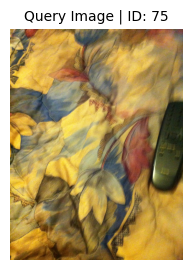

   Query Question: What is this?

------------------------------ SEARCH RESULTS ------------------------------


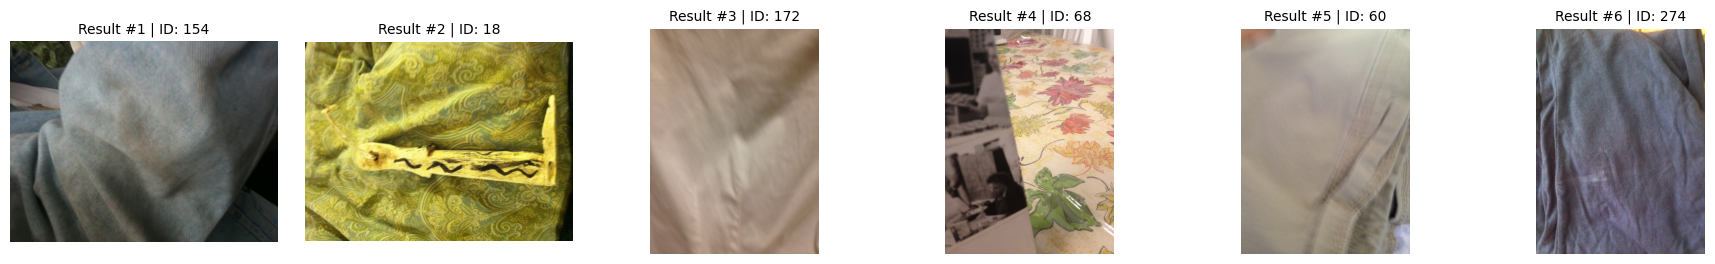

  Result #1 Details:
     Question: Hi, what color is this jacket?
     Answerability: answerable
     Distance: 0.6038

  Result #2 Details:
     Question: What is this?
     Answerability: unanswerable
     Distance: 0.6128

  Result #3 Details:
     Question: What color is this shirt?
     Answerability: answerable
     Distance: 0.6138

  Result #4 Details:
     Question: What is this product?
     Answerability: unanswerable
     Distance: 0.6180

  Result #5 Details:
     Question: What is this?
     Answerability: unanswerable
     Distance: 0.6373

  Result #6 Details:
     Question: What color is this please?
     Answerability: answerable
     Distance: 0.6485



In [60]:



print("\n\n" + "="*80)
print("🚀 FINAL STEP: Testing Similarity Search with Horizontal Plotting")
print("="*80)

target_id_to_test = "75"

print(f"\n🎯 Attempting to find and test with VALIDATION ID: {target_id_to_test}")

validation_file_path = "./data/embeddings/lf_vqa_validation_embeddings_openclip.json"
query_embedding = None
query_metadata = None

try:
    with open(validation_file_path, 'r') as f:
        validation_data = json.load(f)
    print(f"📁 Loaded validation file '{validation_file_path}' with {validation_data['count']} embeddings.")
    
    target_item = next((item for item in validation_data['items'] if item.get('id') == target_id_to_test), None)
            
    if target_item is None:
        raise ValueError(f"ID '{target_id_to_test}' not found in the validation file.")

    query_embedding = target_item['embedding'][0]
    query_metadata = target_item['metadata']
    
    # --- Plot the query image (using the single-image helper) ---
    query_image_url = query_metadata.get('image_url', 'N/A')
    show_query_image(query_image_url, title=f"Query Image | ID: {target_id_to_test}")
    print(f"   Query Question: {query_metadata.get('question', 'N/A')}")
    
    # --- Perform the search ---
    results = db.search_similar_images(query_embedding, n_results=7)
    filtered_results = [res for res in results['similar_images'] if res.get('id') != target_id_to_test]
    final_results_to_display = filtered_results

    if not final_results_to_display:
        print("\n   No other similar images were found in the database.")
    else:
        # --- Display results using the new horizontal plotting function ---
        show_results_horizontally(final_results_to_display)
        
except FileNotFoundError:
    print(f"❌ File not found: {validation_file_path}")
except ValueError as ve:
    print(f"❌ {ve}")
except Exception as e:
    print(f"❌ An error occurred during the test: {e}")

# Testing Query